In [25]:
%matplotlib inline

In [27]:
from pathlib import Path

import corner
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from scipy.stats import spearmanr
import tqdm

from relaxed.cosmo import get_t_from_a
from relaxed.fits import get_early_late
from relaxed.mah import get_mah


In [30]:
mah_data = get_mah("../../data/processed/bolshoi_m12", cutoff_missing=0.05, cutoff_particle=0.05)

cat = mah_data["cat"]
am = mah_data["am"]
ma = mah_data['ma']
ma_peak = mah_data['ma_peak']
mpeak = mah_data['mpeak']
scales = mah_data['scales']
mass_bins = mah_data["mass_bins"]

t = get_t_from_a(scales) # in Gyrs
t0 = get_t_from_a(1) # in Gyrs

In [31]:
len(scales)

165

In [24]:
# load diffmah parameters
pars = np.load('../../data/processed/pbest_diffmah.npy')
logtc, ue, ul = pars[:, 0], pars[:, 1], pars[:, 2]
alpha_early, alpha_late = get_early_late(ue, ul)
tc = 10**logtc
cat.add_column(tc, name="tau_c")
cat.add_column(alpha_early, name="alpha_early")
cat.add_column(alpha_late, name="alpha_late")

NameError: name 'get_early_late' is not defined

In [19]:
# get diffmah curves (by hand)
from relaxed.fits import alpha_diffmah
t = t.reshape(1, -1)
tc = tc.reshape(-1, 1)
alpha_early = alpha_early.reshape(-1, 1)
alpha_late = alpha_late.reshape(-1, 1)
curves = (t / t0) ** alpha_diffmah(t, tc, alpha_early, alpha_late) * mpeak.reshape(-1, 1)
t = t.reshape(-1)

/home/imendoza/nbody-relaxed/relaxed/fits.py:62: RuntimeWarning: overflow encountered in exp
  return alpha_early + (alpha_late - alpha_early) / (1 + np.exp(-k * (t - tau_c)))


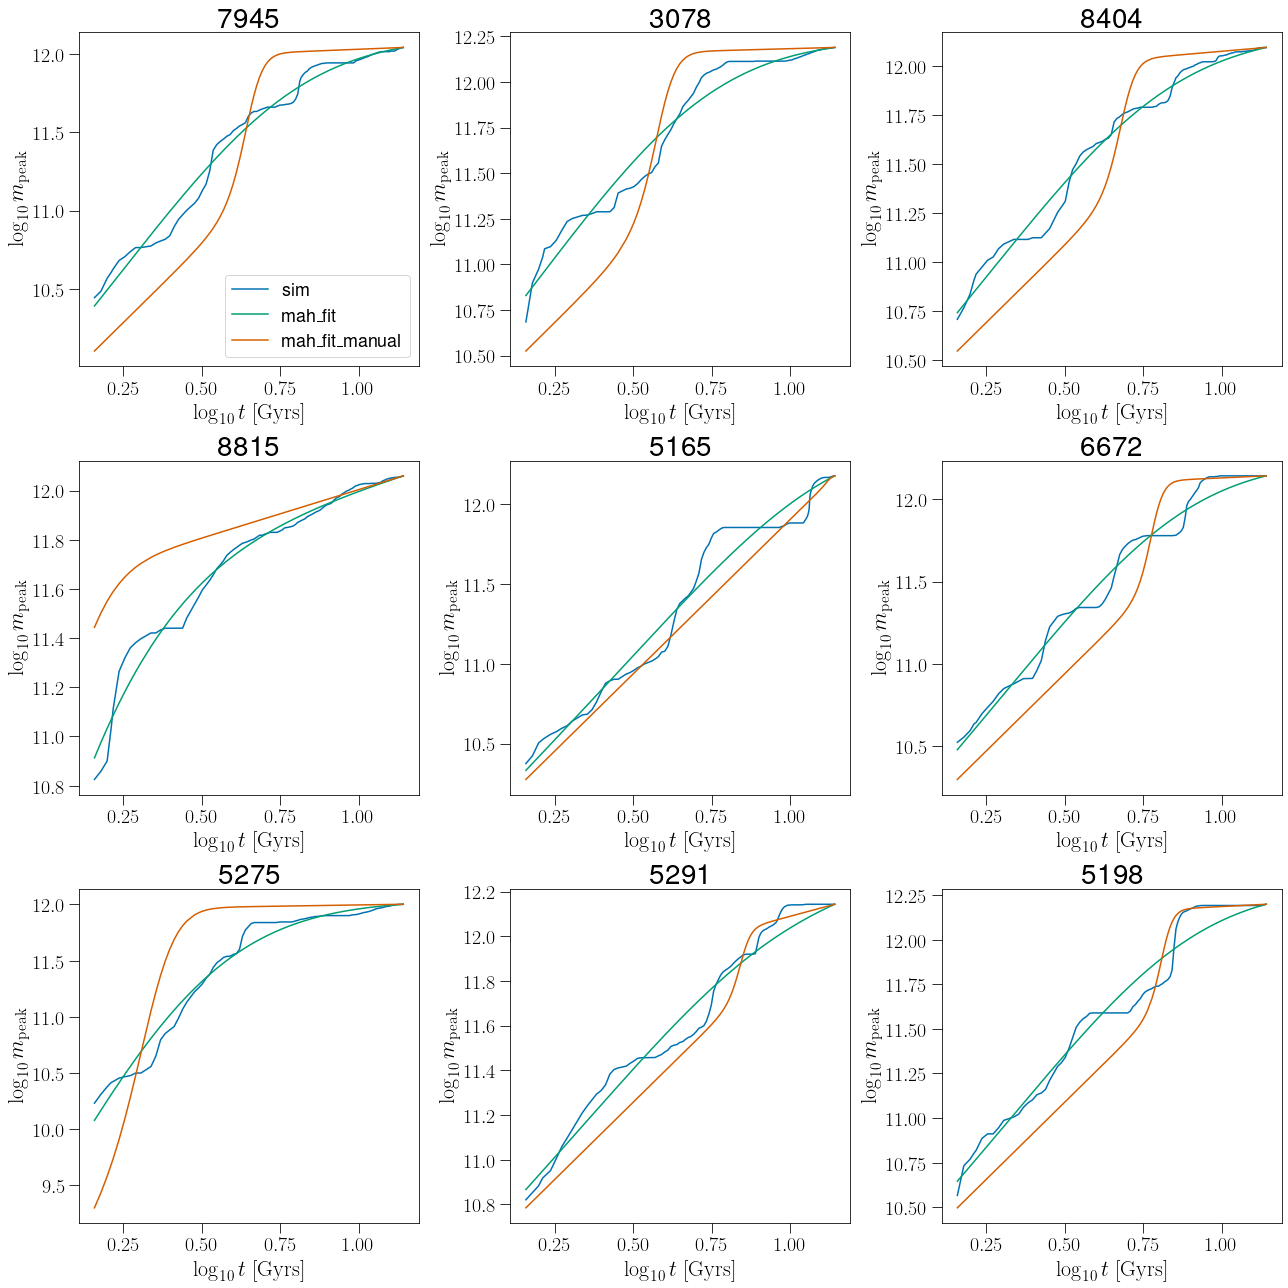

In [23]:
# andrews way of getting curves
from diffmah.individual_halo_assembly import _get_early_late
from diffmah.individual_halo_assembly import _calc_halo_history
from diffmah.fit_mah_helpers import get_loss_data

log_mah = np.log10(ma_peak * mpeak.reshape(-1, 1))
log_min_mass = np.log10(100 * 1.35e8)

indices = np.random.randint(0, len(pars), 9)
fig, axes = plt.subplots(3, 3, figsize=(18, 18))


for ii, (idx, ax) in enumerate(zip(indices, axes.flatten())):
    logtc, ue, ul = pars[idx, 0], pars[idx, 1], pars[idx, 2]
    
    p_init, loss_data = get_loss_data(t, log_mah[idx, :], log_min_mass)
    logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data
    early, late = _get_early_late(ue, ul)

    logt = np.log10(t)
    dmhdt_fit, log_mah_fit = _calc_halo_history(logt, logt[-1], logmp_fit, logtc, 3.5, early, late)

   
    ax.plot(logt_target, log_mah_target, label='sim')
    ax.plot(logt, log_mah_fit, label='mah_fit')
    ax.plot(logt, np.log10(curves[idx, :]), label='mah_fit_manual')
    ax.set_xlabel(r"$\log_{10} t \; [\rm Gyrs]$", size=22)
    ax.set_ylabel(r"$\log_{10} m_{\rm peak}$", size=22)
    ax.set_title(idx)
    if ii == 0: 
        ax.legend(prop=dict(size=18), loc='best')
    ax.tick_params(axis='both', labelsize=20)
plt.tight_layout()



In [25]:
# andrews way of getting curves
from diffmah.individual_halo_assembly import _get_early_late
from diffmah.individual_halo_assembly import _calc_halo_history
from diffmah.fit_mah_helpers import get_loss_data

log_mah = np.log10(ma_peak * mpeak.reshape(-1, 1))
log_min_mass = np.log10(100 * 1.35e8)

diffmah_curves = []

for ii in tqdm.tqdm(range(len(pars))):
    logtc, ue, ul = pars[ii, 0], pars[ii, 1], pars[ii, 2]
    
    p_init, loss_data = get_loss_data(t, log_mah[ii, :], log_min_mass)
    logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data
    early, late = _get_early_late(ue, ul)

    logt = np.log10(t)
    dmhdt_fit, log_mah_fit = _calc_halo_history(logt, logt[-1], logmp_fit, logtc, 3.5, early, late)
    diffmah_curves.append(log_mah_fit)

diffmah_curves = np.array(diffmah_curves)

100%|██████████| 10000/10000 [00:03<00:00, 2528.18it/s]


In [27]:
diffmah_curves_norm = 10**diffmah_curves / mpeak.reshape(-1, 1)

In [33]:
np.save("../../data/processed/diffmah_fits.npy", diffmah_curves_norm)

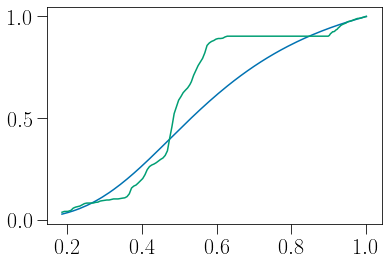

In [36]:
plt.plot(scales, diffmah_curves_norm[4, :])
plt.plot(scales, ma_peak[4, :])